--- 1. Carregando e Pré-processando os Dados ---
--- Pré-processamento Concluído ---

--- 2. Dividindo os Dados (Treino e Teste) ---
Tamanho do conjunto de Treino: 319 amostras
Tamanho do conjunto de Teste: 137 amostras
Distribuição de 'positivos' no Treino: 95 (29.8%)
Distribuição de 'positivos' no Teste:  41 (29.9%)

--- 3. Modelo 1 (Rápido): Treinando com class_weight='balanced' ---
--- Treinamento do Modelo 1 Concluído ---

--- 4. Avaliando o Modelo 1 (Balanced) ---
Acurácia (Modelo 1): 0.5255

Relatório de Classificação (Modelo 1):
              precision    recall  f1-score   support

negativo (0)       0.76      0.47      0.58        96
positivo (1)       0.35      0.66      0.45        41

    accuracy                           0.53       137
   macro avg       0.55      0.56      0.52       137
weighted avg       0.64      0.53      0.54       137


Matriz de Confusão (Modelo 1):
[[45 51]
 [14 27]]


--- 5. Modelo 2 (Otimizado): Buscando Melhores Hiperparâmetros ---
--- Otimiz

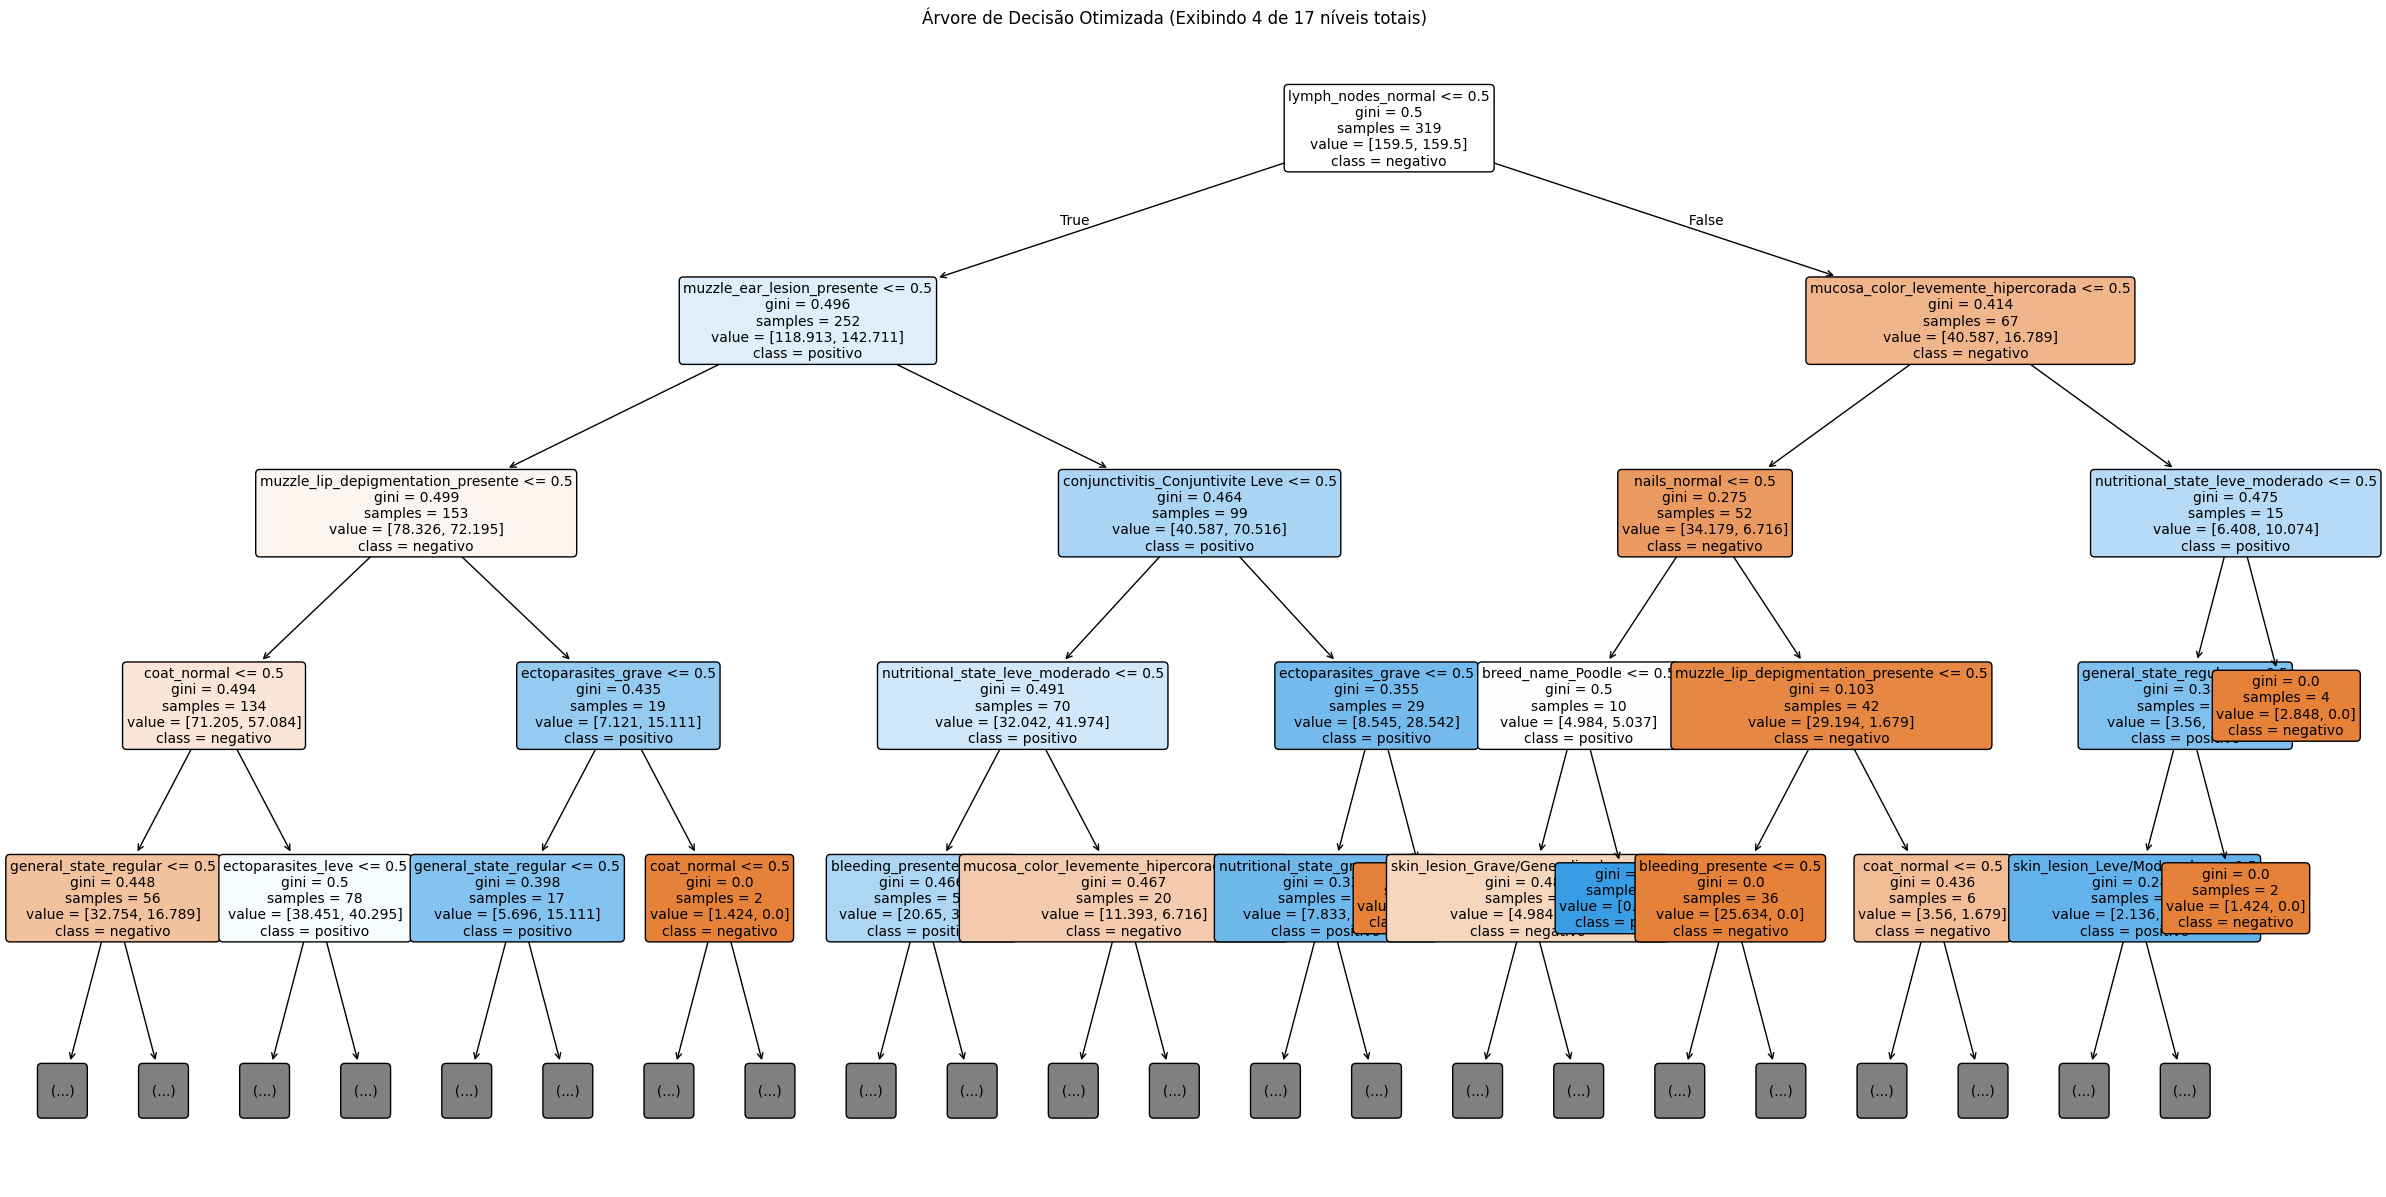

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    make_scorer,  # Importado para o GridSearchCV
    f1_score      # Usaremos f1_macro como nossa métrica de "sucesso"
)
import matplotlib.pyplot as plt

# ==============================================================================
# --- 1. Carregando e Pré-processando os Dados (Seu código) ---
# ==============================================================================
print("--- 1. Carregando e Pré-processando os Dados ---")

# ... (Seu código de carregamento e pré-processamento) ...
# (Ocultado por brevidade, mas é o mesmo código que você já tem)
# ... (Seu código de carregamento e pré-processamento) ...

# Carregar o dataset
file_path = '../data/raw/leish_dataset.csv'
df = pd.read_csv(file_path)

# Criar cópia para processamento
df_processed = df.copy()

# Lidar com valores ausentes (Missing)
for col in df_processed.select_dtypes(include=['object']).columns:
    df_processed[col] = df_processed[col].fillna('Unknown')

# Codificar a variável Alvo (Target)
target_map = {'positivo': 1, 'negativo': 0, 'Unknown': 0}
df_processed['diagnosis'] = df_processed['diagnosis'].map(target_map).astype(int)

# Separar features (X) e alvo (y)
X_categorical = df_processed.drop('diagnosis', axis=1)
y = df_processed['diagnosis']

# Aplicar One-Hot Encoding nas features categóricas
X_numeric = pd.get_dummies(X_categorical, drop_first=True, dtype=int)

print("--- Pré-processamento Concluído ---")


# ==============================================================================
# --- 2. Dividindo os Dados (Treino e Teste) ---
# ==============================================================================
print("\n--- 2. Dividindo os Dados (Treino e Teste) ---")

X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, 
    y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Tamanho do conjunto de Treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de Teste: {X_test.shape[0]} amostras")
print(f"Distribuição de 'positivos' no Treino: {sum(y_train)} ({sum(y_train)/len(y_train)*100:.1f}%)")
print(f"Distribuição de 'positivos' no Teste:  {sum(y_test)} ({sum(y_test)/len(y_test)*100:.1f}%)")


# ==============================================================================
# --- 3. Modelo 1: Árvore Simples com `class_weight='balanced'` ---
# ==============================================================================
print("\n--- 3. Modelo 1 (Rápido): Treinando com class_weight='balanced' ---")

# A ÚNICA MUDANÇA ESTÁ AQUI: class_weight='balanced'
# Isso diz ao modelo para penalizar mais os erros na classe minoritária (positivo)
dt_balanced = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,       # Mantendo a profundidade original por enquanto
    random_state=42,
    class_weight='balanced'  # <--- A CORREÇÃO MÁGICA
)

dt_balanced.fit(X_train, y_train)
print("--- Treinamento do Modelo 1 Concluído ---")

# --- Avaliando o Modelo 1 ---
print("\n--- 4. Avaliando o Modelo 1 (Balanced) ---")
y_pred_balanced = dt_balanced.predict(X_test)

print(f"Acurácia (Modelo 1): {accuracy_score(y_test, y_pred_balanced):.4f}")
print("\nRelatório de Classificação (Modelo 1):")
print(classification_report(y_test, y_pred_balanced, target_names=['negativo (0)', 'positivo (1)']))

print("\nMatriz de Confusão (Modelo 1):")
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
print(cm_balanced)


# ==============================================================================
# --- 5. Modelo 2: Otimização com GridSearchCV ---
# ==============================================================================
print("\n\n--- 5. Modelo 2 (Otimizado): Buscando Melhores Hiperparâmetros ---")

# 1. Definir o "grid" de parâmetros que queremos testar
# Vamos testar diferentes profundidades, critérios de divisão, etc.
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 7, 10, None], # Testar várias profundidades
    'min_samples_leaf': [1, 3, 5],       # Mínimo de amostras em um nó "folha"
    'min_samples_split': [2, 5, 10],     # Mínimo para dividir um nó
    'class_weight': ['balanced']         # Manter isso!
}

# 2. Definir a métrica de sucesso
# Não queremos 'accuracy'. Queremos f1-score, que balança precisão e recall.
# 'f1_macro' calcula o F1 para cada classe e tira a média, sem dar peso
# maior para a classe majoritária (negativos). Perfeito para nós.
f1_macro_scorer = make_scorer(f1_score, average='macro')

# 3. Inicializar o GridSearchCV
# cv=5 significa "Cross-Validation" de 5 dobras (divide o treino em 5 partes)
# n_jobs=-1 usa todos os processadores do seu PC para acelerar a busca
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), # O modelo base
    param_grid=param_grid,                             # O grid para testar
    scoring=f1_macro_scorer,                           # Nossa métrica de sucesso
    cv=5,                                              # Cross-Validation
    n_jobs=-1                                          # Usar todos os cores
)

# 4. Treinar! (Isso pode demorar alguns segundos)
grid_search.fit(X_train, y_train)

# 5. Pegar o melhor modelo encontrado
best_dt = grid_search.best_estimator_

print("--- Otimização do Modelo 2 Concluída ---")
print(f"\nMelhores parâmetros encontrados: {grid_search.best_params_}")
print(f"Melhor pontuação (f1_macro) no treino: {grid_search.best_score_:.4f}")


# ==============================================================================
# --- 6. Avaliação Final (Melhor Modelo - GridSearchCV) ---
# ==============================================================================
print("\n--- 6. Avaliando o Melhor Modelo (GridSearchCV) no Teste ---")

# Usar o modelo campeão para prever no conjunto de TESTE
y_pred_best = best_dt.predict(X_test)

print(f"Acurácia (Modelo Otimizado): {accuracy_score(y_test, y_pred_best):.4f}")
print("\nRelatório de Classificação (Modelo Otimizado):")
print(classification_report(y_test, y_pred_best, target_names=['negativo (0)', 'positivo (1)']))

print("\nMatriz de Confusão (Modelo Otimizado):")
cm_best = confusion_matrix(y_test, y_pred_best)
print(f"            [Prev. Neg] [Prev. Pos]")
print(f"[Real Neg]  {cm_best[0][0]:>10} {cm_best[0][1]:>10}")
print(f"[Real Pos]  {cm_best[1][0]:>10} {cm_best[1][1]:>10}")


# ==============================================================================
# --- 7. Visualizando a Árvore Otimizada ---
# ==============================================================================
print("\n--- 7. Gerando a Visualização da Árvore Otimizada ---")

feature_names = X_numeric.columns.tolist()
class_names = ['negativo', 'positivo']

plt.figure(figsize=(30, 15)) # Figura maior

# Plotar a árvore
# Vamos exibir os 4 primeiros níveis para legibilidade.
# O modelo real (best_dt.get_depth()) pode ser mais profundo.
plot_tree(
    best_dt, # Usando o melhor modelo do GridSearch
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=4 # Exibir apenas os 4 primeiros níveis
)

plt.title(f"Árvore de Decisão Otimizada (Exibindo 4 de {best_dt.get_depth()} níveis totais)")
plt.savefig("decision_tree_optimized.png")

print("--- Visualização salva em 'decision_tree_optimized.png' ---")
# plt.show()